# AVERAGE MODEL

In [35]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.utils import load_data, save_model, save_metrics, evaluate, save_figure, get_oof_preds
from src.models import get_model

# Chuyển cwd về gốc dự án nếu đang ở notebooks/
try:
    if Path(os.getcwd()).name == "notebooks":
        os.chdir("..")
        print(f"CWD đã chuyển sang: {os.getcwd()}")
except:
    pass


# 1. LOAD DATA

In [36]:
X, y = load_data()

print(f"Shape của tập X_train: {X.shape}")
print(f"Shape của tập y_train: {y.shape}")
print("\n5 dòng đầu của X (Features):")
X.head()

Shape của tập X_train: (1458, 338)
Shape của tập y_train: (1458,)

5 dòng đầu của X (Features):


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2.227075,19.212182,7,2003,2003,8.059126,11.170327,0.0,2.520750,856.0,...,False,False,False,True,False,False,False,False,True,False
1,2.301430,19.712205,6,1976,1976,0.000000,12.062832,0.0,2.735757,1262.0,...,False,False,False,True,False,False,False,False,True,False
2,2.243319,20.347241,7,2001,2002,7.646538,10.200343,0.0,2.875008,920.0,...,False,False,False,True,False,False,False,False,True,False
3,2.198137,19.691553,7,1915,1970,0.000000,8.274266,0.0,2.945797,756.0,...,False,False,False,True,True,False,False,False,False,False
4,2.318756,21.325160,8,2000,2000,9.391827,10.971129,0.0,2.914398,1145.0,...,False,False,False,True,False,False,False,False,True,False


# 2. LOAD CÁC MODEL ĐÃ ĐƯỢC TUNE

In [37]:
def load_base_model(name):
    model_path = Path(f"models/{name}.pkl")
    if model_path.exists():
        print(f"Đã load model từ {model_path}")
        return joblib.load(model_path)
    else:
        print(f" Không có {name}.pkl — dùng model mặc định.")
        return get_model(name)

model_names = ["ridge", "xgboost", "lightgbm", "random_forest", "linear"]

base_models = [load_base_model(name) for name in model_names]

print("Danh sách models trong ensemble:", model_names)


Đã load model từ models/ridge.pkl
Đã load model từ models/xgboost.pkl
Đã load model từ models/lightgbm.pkl
Đã load model từ models/random_forest.pkl
Đã load model từ models/linear.pkl
Danh sách models trong ensemble: ['ridge', 'xgboost', 'lightgbm', 'random_forest', 'linear']


# 3. ĐỊNH NGHĨA CLASS AVERAGING MODELS

In [38]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        # clone từng model để tránh ghi đè model load từ .pkl
        self.models_ = [clone(m) for m in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        preds = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(preds, axis=1)


# 4. KHỞI TẠO MÔ HÌNH VÀ HUẤN LUYỆN MÔ HÌNH AVERAGING_MODEL

In [39]:
model_name = "averaging"

# 1. TÍNH OOF CHO TỪNG BASE MODEL
print("Đang tính OOF Predictions cho từng mô hình cơ sở...")

oof_predictions_list = []
# Lặp qua từng base model để lấy OOF riêng biệt
for model in base_models:
    # Hàm get_oof_preds sẽ tự fit và dự đoán 5 lần cho mỗi model
    oof_p = get_oof_preds(model, X, y)
    oof_predictions_list.append(oof_p)
    
# Tính trung bình (Averaging) các OOF predictions
oof_preds = np.mean(oof_predictions_list, axis=0)

# 2. KHỞI TẠO VÀ HUẤN LUYỆN ENSEMBLE 
ensemble_model = AveragingModels(models=base_models)

print("\nBắt đầu huấn luyện averaging ensemble model trên toàn bộ dữ liệu...")
# Fit model 1 lần cuối trên toàn bộ tập dữ liệu để lưu trữ (Production Model)
ensemble_model.fit(X, y)
best_model = ensemble_model 

Đang tính OOF Predictions cho từng mô hình cơ sở...

Bắt đầu huấn luyện averaging ensemble model trên toàn bộ dữ liệu...


# 5. ĐÁNH GIÁ MÔ HÌNH 

In [40]:
metrics = evaluate(y, oof_preds)

print(f"\n{model_name.upper()} Metrics (OOF):")
print("-" * 30)
for metric, value in metrics.items():
    if isinstance(value, np.float64):
        value = float(value)
    print(f"  - {metric.upper()}: {value:.4f}")

save_metrics(model_name, metrics)
print("-" * 30)
print("Kết quả đã được lưu vào results/metrics.json")


AVERAGING Metrics (OOF):
------------------------------
  - RMSE: 0.1140
  - MAE: 0.0773
  - R2: 0.9186
------------------------------
Kết quả đã được lưu vào results/metrics.json


# 6. TRỰC QUAN HOÁ KẾT QUẢ 

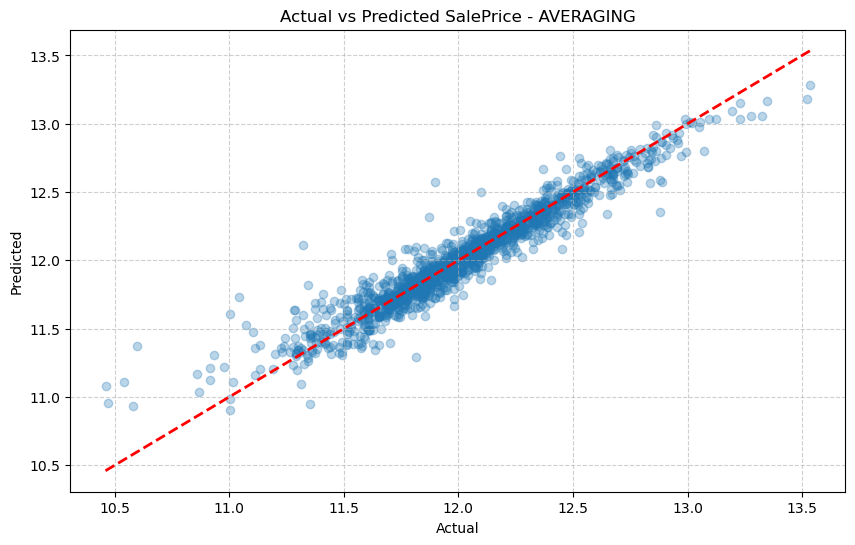

Hình ảnh đã lưu thành công tại: results/figures/averaging_model_actual_vs_predicted.png


In [41]:
filename_to_save = 'averaging_model_actual_vs_predicted.png' 
figure_path = f'results/figures/{filename_to_save}' 

fig, ax = plt.subplots(figsize=(10, 6)) 

ax.scatter(y, oof_preds, alpha=0.3)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) 
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title(f'Actual vs Predicted SalePrice - {model_name.upper()}')
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()
save_figure(fig, filename=filename_to_save) 



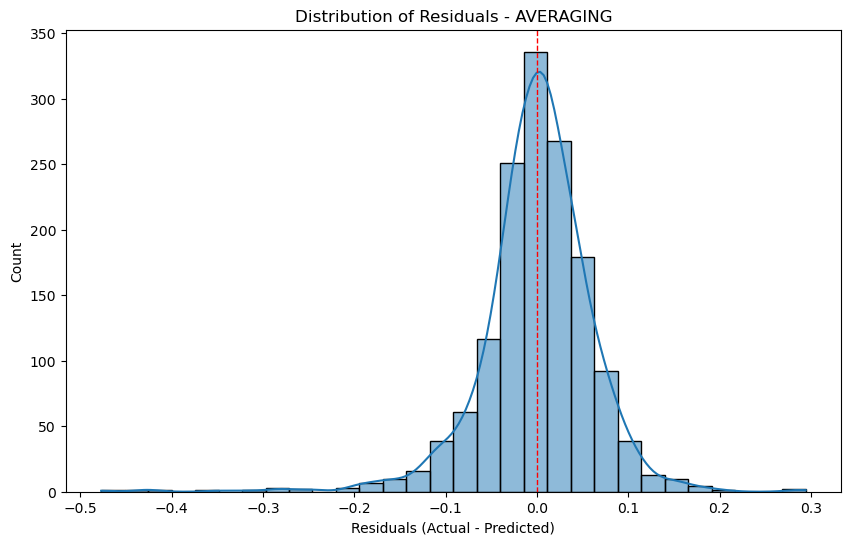

Hình ảnh đã lưu thành công tại: results/figures/averaging_model_actual_vs_predicted.png


In [42]:
oof_pred_averaging = ensemble_model.predict(X)
residuals = y - oof_pred_averaging
figure_path_res = 'results/figures/averaging_model_residuals.png'

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals (Actual - Predicted)')
plt.title(f'Distribution of Residuals - {model_name.upper()}')
plt.savefig(figure_path_res)
plt.show()

save_figure(fig, filename=filename_to_save) 

# 7. LƯU MODEL 

In [43]:
save_model(best_model, model_name)
print(f"Mô hình {model_name} đã được lưu thành công tại models/{model_name}.pkl")

Mô hình averaging đã được lưu thành công tại models/averaging.pkl
